In [ ]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

import cv2

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [ ]:
images = lfw_people.data
print(lfw_people.images.shape)
images.shape

(1288, 50, 37)


(1288, 1850)

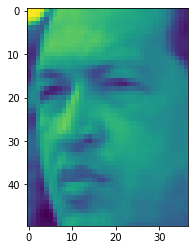

In [ ]:
IMG_W = 50
IMG_H = 37
plt.imshow(images[0].reshape(50,37)/255)

In [ ]:
from torch.utils import data

train = images[200:] / 255
test = images[:200] / 255

train = torch.tensor(train)
test = torch.tensor(test)

train_dataset = data.TensorDataset(train) 
train_loader = data.DataLoader(train_dataset, batch_size=1) 

test_dataset = data.TensorDataset(test) 
test_loader = data.DataLoader(test_dataset, batch_size=1) 

In [ ]:
class LinearMasked(nn.Module):
    def __init__(self, in_features, out_features, num_input_features, seed=0, bias=True):
        """

        Parameters
        ----------
        in_features : int
        out_features : int
        num_input_features : int   global value for the first input ever
            Number of features of the models input X.
            These are needed for all masked layers.
        bias : bool
        """
        super(LinearMasked, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        self.num_input_features = num_input_features

        assert (
            out_features >= num_input_features
        ), "To ensure autoregression, the output there should be enough hidden nodes. h >= in."

        # Make sure that d-values are assigned to m
        # d = 1, 2, ... D-1
        d = set(range(1, num_input_features))
    

        """
        Let's say we have 4 feature inputs, therefore we zero 4th dimension by not including it.
        We will use 4 numbers in the input but each next layer will have max 4-1 label.
        Note, we use zeroing maks below

        """

        self.m = np.random.permutation(range(1, out_features+1))
        self.m[self.m >= num_input_features] = np.random.randint(1,  in_features, size=np.sum(self.m >= num_input_features))
        assert len(d - set(self.m)) == 0 , 'number of dimensions is not matching '
        self.m = torch.from_numpy(self.m)

        self.register_buffer(
            "mask", torch.ones_like(self.linear.weight).type(torch.uint8)
        )
        
    def set_mask(self, m_previous_layer):
        """
        Sets mask matrix of the current layer.

        Parameters
        ----------
        m_previous_layer : tensor
            m values for previous layer.
            The first layers should be incremental except for the last value,
            as the model does not make a prediction P(x_D+1 | x_<D + 1).
            The last prediction is P(x_D| x_<D)
        
        here we get a tensor of size:

        for ex. : m_prev = 1,2,1
                       m = 1,2

        [[ True, False,  True],
         [ True,  True,  True]]
        
        """

        self.mask[...] = (m_previous_layer[:, None] <= self.m[None, :]).T

    def forward(self, x):
        if self.linear.bias is None:
            b = 0
        else:
            b = self.linear.bias
        return F.linear(x, self.linear.weight * self.mask, b)

In [ ]:
def set_mask_output_layer(layer, m_previous_layer):
    
    # Output layer has different m-values.
    # The connection is shifted one value to the right.
    # In the first layer the first output is conditioned on itself.

    layer.m = torch.arange(0, layer.num_input_features)
    layer.set_mask(m_previous_layer)
    return layer


def set_mask_input_layer(layer):
    m_input_layer = torch.arange(1, layer.num_input_features + 1)
    m_input_layer[-1] = 1e9 
    layer.set_mask(m_input_layer)
    return layer


class SequentialMasked(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)

        input_set = False
        for i in range(len(args)):
            layer = self.__getitem__(i)
            if not isinstance(layer, LinearMasked):
                continue
            if not input_set:
                layer = set_mask_input_layer(layer)
                m_previous_layer = layer.m
                input_set = True
            else:
                layer.set_mask(m_previous_layer)
                m_previous_layer = layer.m

    def set_mask_last_layer(self):
        reversed_layers = filter(
            lambda l: isinstance(l, LinearMasked), reversed(self._modules.values())
        )

        # Get last masked layer
        layer = next(reversed_layers)
        prev_layer = next(reversed_layers)
        set_mask_output_layer(layer, prev_layer.m)

In [ ]:
class MADE(nn.Module):
    # Don't use ReLU, so that neurons don't get nullified.
    # This makes sure that the autoregressive test can verified
    def __init__(self, in_features, hidden_features, num_layers):

        super().__init__()
        self.layers = []

        for i in range(num_layers):
            self.layers.append(LinearMasked(in_features, hidden_features, in_features))
            self.layers.append(nn.ELU())
            in_features = hidden_features
        
        self.layers.append(LinearMasked(in_features, hidden_features, in_features))
        self.layers.append(nn.Sigmoid())
        # Note that we don’t use ReLU activations. A ReLU(Wx+b)=max(0,Wx+b), leading to nullified connections.    
        self.layers = SequentialMasked(*self.layers)
        self.layers.set_mask_last_layer()

    def forward(self, x):
        return self.layers(x)

### Test model, last output gradients should be zero


In [ ]:
input_size = 10
x = torch.ones((1, input_size))
x.requires_grad = True

m = MADE(in_features=input_size, hidden_features=20, num_layers=5)

for d in range(input_size):
    x_hat = m(x)
    
    # loss w.r.t. P(x_d | x_<d)
    loss = x_hat[0, d]
    loss.backward()
    
    assert torch.all(x.grad[0, :d] != 0)
    assert torch.all(x.grad[0, d:] == 0)

In [ ]:
def train_step(model, 
               train_loader, 
               optimizer, 
               loss_fn,
               grad_clip = False):
    
    losses = []
    model.train()
    for b in train_loader:
        optimizer.zero_grad()
        
        x = b[0].cuda()
        out = model(x)

        loss = loss_fn(out, x)
        loss.backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        losses.append(loss.item())
    return losses


In [ ]:
del model

torch.cuda.empty_cache()

input_size = IMG_H*IMG_W
hidden_features = IMG_H*IMG_W

model =  MADE(in_features=input_size, hidden_features=hidden_features, num_layers=2)
model.cuda()

def train_epochs(epochs, train_loader, test_loader):
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn =  nn.BCELoss() #F.cross_entropy  #torch.nn.CrossEntropyLoss()

    for i in range(epochs):
        losses = train_step(model, train_loader, optimizer, loss_fn)
        print(f'epoch {i+1} loss =  {np.mean(losses)}')

RuntimeError: ignored

In [ ]:
train_epochs(20, test_loader, test_loader)

RuntimeError: ignored

In [ ]:
iterable = iter(test_loader)
for i in range(3):
    img = next(iterable)[0]
img = img[0].cuda()
out = model(img)

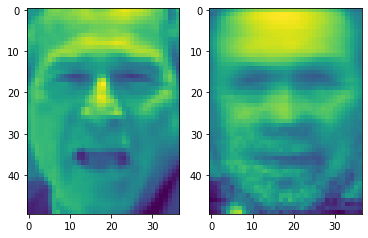

In [ ]:
f, ax = plt.subplots(1,2)
ax[0].imshow(img.cpu().detach().numpy().reshape(IMG_W, IMG_H))
img_pred = out.cpu().detach().numpy().reshape(IMG_W, IMG_H)
ax[1].imshow(img_pred)

In [ ]:
new_img = torch.zeros_like(img)
for i in range(len(new_img)):
    x = model(new_img)
    new_img[d] = x[d]

    

RuntimeError: ignored

In [ ]:
input

tensor([[ 0.3322,  0.5799,  0.9646, -0.6971, -0.1969],
        [-0.3373, -0.5294,  0.5068,  0.1383,  0.3783],
        [-0.1060, -0.2247, -0.8537, -1.6776, -0.2317]], requires_grad=True)

In [ ]:
target

tensor([1, 1, 2])